## Modelo P1 usando **XGBoost**

* [Carga de los datos](#carga-de-los-datos)
* [Modelo Baseline](#modelo-baseline)
* [Transformaciones](#transformaciones)
* [Selección de variables](#selección-de-variables)
* [Ajuste de hiperparámetros](#ajuste-de-hiperparámetros)
* [Conclusiones](#conclusiones)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import  GridSearchCV, RandomizedSearchCV,train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,log_loss, make_scorer, f1_score, roc_auc_score, precision_score, recall_score
import os
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow
import random

In [2]:
np.random.seed(42)
random.seed(42)

### Descripción general del notebook

En este notebook realizaremos el modelado y entrenamiento de un modelo XGBoost para predecir el ganador de una pelea a partir de los datos disponibles.

En la fase de entrenamiento, buscaremos los hiperparámetros óptimos utilizando dos estrategias de ajuste. Primero, construiremos un modelo base (baseline), a partir del cual extraeremos conclusiones iniciales e intentaremos mejorarlo mediante dos técnicas de ajuste de hiperparámetros.

Para este ajuste, emplearemos las estrategias de búsqueda en rejilla (grid search) y búsqueda aleatoria (random search). Evaluaremos los modelos utilizando el F1-score con validación cruzada, dado que la variable de respuesta presenta un desbalance y queremos evitar que el modelo prediga predominantemente la clase mayoritaria.

El modelo con mejores resultados en la validación cruzada será seleccionado y analizaremos sus métricas en mayor profundidad.

El objetivo principal es obtener un modelo con una accuracy lo suficientemente alta para su posterior implementación en la fase de despliegue.

In [3]:
ruta_mlflow = os.path.abspath(os.path.join("..", "..", "..", "mlruns"))

# Configurar MLflow para guardar los modelos en esa ruta
mlflow.set_tracking_uri(f"file:///{ruta_mlflow}")

print("MLflow tracking URI:", mlflow.get_tracking_uri())  

MLflow tracking URI: file:///c:\Users\mattu\OneDrive\Documentos\GitHub\c2425-R4\mlruns


In [4]:
mlflow.set_experiment("Modelos datos de pelas con XGBoost P1, datos finales")

2025/03/26 11:24:33 INFO mlflow.tracking.fluent: Experiment with name 'Modelos datos de pelas con XGBoost P1, datos finales' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///c:\\Users\\mattu\\OneDrive\\Documentos\\GitHub\\c2425-R4\\mlruns/263253257679927349', creation_time=1742984673458, experiment_id='263253257679927349', last_update_time=1742984673458, lifecycle_stage='active', name='Modelos datos de pelas con XGBoost P1, datos finales', tags={}>

Guardamos los resultados de diferentes experimentos en la carpeta mlruns para comprobar diferentes modelos.

#### CARGA DE DATOS

Cargo los datos de train y test. Los cuales ya tenemos guardados en la carpeta data. Separamos en "X" e "y", guardando en "X" las variables que introduciremos en el modelo, eliminamos algunas variables que no aportan información sobre las peleas o variables que al realizar modelos observamos que tienen una importancia prácticamente nula. En la variable "y" guardamos la variable respuesta.

In [5]:
#Leo los df divididos en orden cronológico de forma que los resultados sean lo más reales posibles
ruta_train =  os.path.join("..","..", "..", "data", "P1","train.parquet")
df_train = pd.read_parquet(ruta_train)
df_train.head()

,Peleador_A,Peleador_B,DATE,CATEGORY,WINNER,METHOD,TIME,ROUND,KD_A,KD_B,...,Victorias_Sub_A,Victorias_Sub_B,Victorias_Decision_A,Victorias_Decision_B,Derrotas_KO_A,Derrotas_KO_B,Derrotas_Sub_A,Derrotas_Sub_B,Derrotas_Decision_A,Derrotas_Decision_B
0,Clay Harvison,Seth Baczynski,2011-09-17,WELTERWEIGHT,True,Submission,72,2,0,1,...,0,1,1,0,0,0,1,0,0,1
1,Simeon Thoresen,Besam Yousef,2012-04-14,WELTERWEIGHT,False,Submission,156,2,0,0,...,1,0,0,0,0,0,0,1,0,0
2,Nate Diaz,Rory MacDonald,2011-04-30,WELTERWEIGHT,True,Decision - Unanimous,300,3,0,0,...,6,1,1,1,0,1,0,0,5,0
3,Edson Barboza,Justin Gaethje,2019-03-30,LIGHTWEIGHT,True,KO/TKO,150,1,0,1,...,0,0,7,0,3,2,2,0,2,0
4,Travis Browne,Brendan Schaub,2014-12-06,HEAVYWEIGHT,False,KO/TKO,290,1,0,0,...,1,1,2,2,1,4,0,0,1,1


In [6]:
ruta_test = os.path.join("..","..", "..","data", "P1","test.parquet")
df_test = pd.read_parquet(ruta_test)
df_test.head()

,Peleador_A,Peleador_B,DATE,CATEGORY,WINNER,METHOD,TIME,ROUND,KD_A,KD_B,...,Victorias_Sub_A,Victorias_Sub_B,Victorias_Decision_A,Victorias_Decision_B,Derrotas_KO_A,Derrotas_KO_B,Derrotas_Sub_A,Derrotas_Sub_B,Derrotas_Decision_A,Derrotas_Decision_B
0,Glover Teixeira,Fabio Maldonado,2012-10-13,LIGHTHEAVYWEIGHT,False,TKO - Doctor's Stoppage,300,2,1,0,...,1,0,0,0,0,1,0,0,0,2
1,Nordine Taleb,Chris Clements,2015-04-25,WELTERWEIGHT,False,Decision - Unanimous,300,3,0,0,...,0,0,3,1,0,1,0,0,0,1
2,Jose Aldo,Kenny Florian,2011-10-08,FEATHERWEIGHT,False,Decision - Unanimous,300,5,0,0,...,0,7,2,2,0,1,0,1,0,3
3,Adriano Martins,Juan Manuel Puig,2014-07-06,LIGHTWEIGHT,False,KO/TKO,141,1,1,0,...,1,0,0,0,1,1,0,0,0,0
4,Brendan Allen,Tom Breese,2020-02-29,MIDDLEWEIGHT,False,KO/TKO,287,1,0,0,...,1,0,0,1,0,1,0,0,0,1


In [7]:
X_train = df_train.drop(columns=["DATE","Peleador_A","Peleador_B","WINNER","CATEGORY","METHOD","ROUND"])
y_train = df_train["WINNER"]
print(y_train.value_counts())
print(y_train.value_counts(normalize=True))

WINNER
False    2691
True     2040
Name: count, dtype: int64
WINNER
False    0.568802
True     0.431198
Name: proportion, dtype: float64


In [8]:
X_test = df_test.drop(columns=["DATE","Peleador_A","Peleador_B","WINNER","CATEGORY","METHOD","ROUND"])
y_test = df_test["WINNER"]
print(y_test.value_counts())
print(y_test.value_counts(normalize=True))

WINNER
False    1179
True      849
Name: count, dtype: int64
WINNER
False    0.581361
True     0.418639
Name: proportion, dtype: float64


Verificamos que los conjuntos tengan una proporción similar de la variable respuesta. Se ve un desequilibrio en la variable respuesta, debemos tener en cuenta que el peleador A suele ser el favorito.

### TRANSFORMACIONES

Para el modelo XGBoost no es necesario realizar transformaciones previas de las variables, como la normalización o estandarización, ya que al ser un modelo basado en árboles de decisión, no se ve afectado por las diferencias en las escalas de los valores ni por la falta de normalidad en la distribución de las variables. Los árboles utilizan divisiones basadas en umbrales y no dependen de operaciones algebraicas sensibles a las magnitudes de las variables.

### SELECCIÓN DE VARIABLES

El modelo XGBoostClassifier no requiere una selección explícita de variables antes del entrenamiento. Al ser un modelo de ensamble de árboles, cada nodo selecciona automáticamente la variable que proporciona la mayor ganancia de información o reducción de impureza. Las variables irrelevantes tienden a ser ignoradas durante las divisiones, por lo que no contribuyen significativamente al modelo final ni añaden ruido. Además, XGBoost incluye regularización, lo que ayuda a reducir aún más el impacto de características poco informativas.

Tan solo eliminamos algunas variables que vimos que tenían una importancia nula o baja para mejorar el coste computacional y variables no útiles que podrían generar problemas.

In [9]:
X_test = X_test.drop(columns=["TITLE_FIGHT","WOMEN"])
X_train = X_train.drop(columns=["TITLE_FIGHT","WOMEN"])

### AJUSTE DE HIPERPARÁMETROS

Para buscar una configuración óptima de hiperparámetros he utilizado dos estrategias, GridSearchCV y RandomizedSearchCV. 

En esta estrategia, he definido una cuadrícula (diccionario) con cada hiperparámetro y los posibles valores que pueden tomar. GridSearchCV realiza una búsqueda exhaustiva probando todas las combinaciones posibles de hiperparámetros, evaluando cada modelo mediante validación cruzada. El objetivo es encontrar la combinación que maximice el rendimiento del modelo según el F1-score. Una vez identificado el mejor conjunto de hiperparámetros, procederemos a estudiar el comportamiento del modelo óptimo.

A diferencia de GridSearchCV, RandomizedSearchCV también explora combinaciones de hiperparámetros, pero en lugar de probar todas las combinaciones posibles, selecciona un número fijo de combinaciones al azar. Esto permite explorar un espacio más amplio de hiperparámetros con un menor costo computacional. Al igual que en la búsqueda exhaustiva, las combinaciones son evaluadas mediante validación cruzada, y se selecciona el modelo que optimiza el F1-score.

#### MODELO BASELINE

Creo un modelo simple el cual debería conseguir mejorar tras realizar los ajustes de hiperparámetros. Para este modelo usaré los hiperparámetros por defecto de XGBoost, sin tener en cuenta los ligeros desbalances de clases.

In [10]:
base = XGBClassifier(random_state=42)
base.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [11]:
print("-- Métricas del modelo con hiperparámetros ajustados --")
y_val_pred = base.predict(X_test)
y_val_prob = base.predict_proba(X_test)[:,1]
print("Accuracy:", accuracy_score(y_test, y_val_pred))
f1_val = f1_score(y_test, y_val_pred)
roc_auc_val = roc_auc_score(y_test, y_val_prob)
precision_val = precision_score(y_test, y_val_pred)
recall_val = recall_score(y_test, y_val_pred)
log_loss_val = log_loss(y_test,y_val_prob)
print(f"F1-Score: {f1_val:.4f}")
print(f"AUC-ROC: {roc_auc_val:.4f}")
print(f"Precisión: {precision_val:.4f}")
print(f"Sensibilidad: {recall_val:.4f}")
print(f"Log-loss: {log_loss_val}")

-- Métricas del modelo con hiperparámetros ajustados --
Accuracy: 0.953155818540434
F1-Score: 0.9433
AUC-ROC: 0.9916
Precisión: 0.9564
Sensibilidad: 0.9305
Log-loss: 0.12199785420441486


Vemos que los resultados sin ajuste de hiperparámetros son buenos, esto nos inidica que los datos son explicativos respecto a la variable respuesta y el modelo elegido funciona correctamente con el problema. Aún así intentaremos mejorar las métricas usando las técnicas de ajuste de hiperparámetros

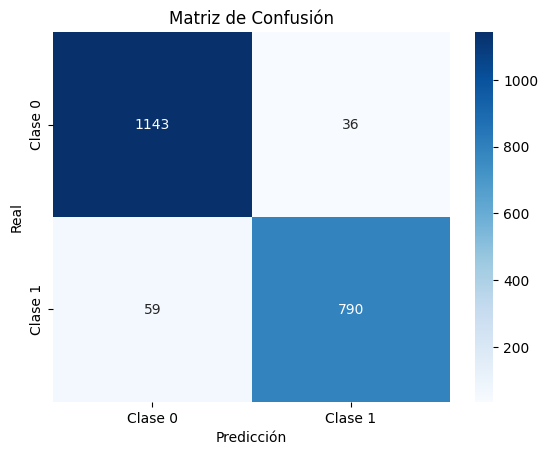

In [12]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_val_pred)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

### TRANSFORMACIONES

Para el modelo XGBoost no es necesario realizar transformaciones previas de las variables, como la normalización o estandarización, ya que al ser un modelo basado en árboles de decisión, no se ve afectado por las diferencias en las escalas de los valores ni por la falta de normalidad en la distribución de las variables. Los árboles utilizan divisiones basadas en umbrales y no dependen de operaciones algebraicas sensibles a las magnitudes de las variables.

### SELECCIÓN DE VARIABLES

El modelo XGBoostClassifier no requiere una selección explícita de variables antes del entrenamiento. Al ser un modelo de ensamble de árboles, cada nodo selecciona automáticamente la variable que proporciona la mayor ganancia de información o reducción de impureza. Las variables irrelevantes tienden a ser ignoradas durante las divisiones, por lo que no contribuyen significativamente al modelo final ni añaden ruido. Además, XGBoost incluye regularización, lo que ayuda a reducir aún más el impacto de características poco informativas.

En nuestro caso eliminamos algunas variables que no aportaban información al modelo para reducir el coste computacional.

### AJUSTE DE HIPERPARÁMETROS

Para buscar una configuración óptima de hiperparámetros he utilizado dos estrategias, GridSearchCV y RandomizedSearchCV. 

En esta estrategia, he definido una cuadrícula (diccionario) con cada hiperparámetro y los posibles valores que pueden tomar. GridSearchCV realiza una búsqueda exhaustiva probando todas las combinaciones posibles de hiperparámetros, evaluando cada modelo mediante validación cruzada. El objetivo es encontrar la combinación que maximice el rendimiento del modelo según el F1-score. Una vez identificado el mejor conjunto de hiperparámetros, procederemos a estudiar el comportamiento del modelo óptimo.

A diferencia de GridSearchCV, RandomizedSearchCV también explora combinaciones de hiperparámetros, pero en lugar de probar todas las combinaciones posibles, selecciona un número fijo de combinaciones al azar. Esto permite explorar un espacio más amplio de hiperparámetros con un menor costo computacional. Al igual que en la búsqueda exhaustiva, las combinaciones son evaluadas mediante validación cruzada, y se selecciona el modelo que optimiza el F1-score.

In [31]:
def train_xgboost_grid(X_train, y_train, X_val, y_val):
    # Calcular pesos de clase para manejar desbalance de datos
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    scale_pos_weight = class_weights[1] / class_weights[0] if len(class_weights) > 1 else 1

    # Definir modelo base
    xgb = XGBClassifier(random_state=42)
    param_grid = {
    'n_estimators': [100, 200],  
    'learning_rate': [0.05,0.1,0.3],  # Evitar valores muy bajos
    'subsample': [0.8, 1.0],  
    'colsample_bytree': [0.7, 1.0],  
    'gamma': [0],  # Reducir la regularización si no es necesaria
    'min_child_weight': [1, 2,5],  # Evitar valores extremos
    'alpha': [0,0.5],  # Si el modelo sin optimizar no usaba regularización
    'lambda': [0.7,1.0],  
    'max_depth':[3,6,12],
    'scale_pos_weight': [1,scale_pos_weight]  
}
    f1_scorer = make_scorer(f1_score, average='macro')

    # Búsqueda con validación cruzada
    grid_search = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        scoring=f1_scorer,  # Optimiza F1-macro
        cv=5,
        n_jobs=-1,
        verbose=2
    )

    # Entrenar el modelo
    grid_search.fit(X_train, y_train)

    # Imprimir mejores parámetros
    print("Mejores parámetros:", grid_search.best_params_)

    # Evaluar el mejor modelo en el conjunto de validación
    y_pred = grid_search.best_estimator_.predict(X_val)
    print("Reporte de clasificación:")
    print(classification_report(y_val, y_pred))

    return grid_search.best_estimator_,grid_search.best_params_

In [32]:
print("-- Entrenamiento usando ajuste de hiperparámetros con GridSearchCV --")
best_grid,best_params = train_xgboost_grid(X_train,y_train,X_test,y_test)

-- Entrenamiento usando ajuste de hiperparámetros con GridSearchCV --
Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
Mejores parámetros: {'alpha': 0, 'colsample_bytree': 0.7, 'gamma': 0, 'lambda': 1.0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 200, 'scale_pos_weight': 1, 'subsample': 0.8}
Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.95      0.97      0.96      1179
        True       0.95      0.94      0.94       849

    accuracy                           0.95      2028
   macro avg       0.95      0.95      0.95      2028
weighted avg       0.95      0.95      0.95      2028



In [34]:
if mlflow.active_run():
    mlflow.end_run()

# Iniciar un nuevo experimento
with mlflow.start_run(run_name="Modelo usando GridSearch auemento de parámetros"):

    # Guardar modelo en MLflow
    mlflow.log_param("mejores_parametros", best_params)
    mlflow.log_metric("accuracy", accuracy_score(y_test, y_val_pred))
    mlflow.log_metric("f1_macro", f1_val)

    print("Modelo guardado en MLflow")

Modelo guardado en MLflow


In [33]:
print("-- Métricas del modelo con hiperparámetros ajustados --")
y_val_pred = best_grid.predict(X_test)
y_val_prob = best_grid.predict_proba(X_test)[:,1]
print("Accuracy:", accuracy_score(y_test, y_val_pred))
f1_val = f1_score(y_test, y_val_pred)
roc_auc_val = roc_auc_score(y_test, y_val_prob)
precision_val = precision_score(y_test, y_val_pred)
recall_val = recall_score(y_test, y_val_pred)
log_loss_val = log_loss(y_test,y_val_prob)
print(f"F1-Score: {f1_val:.4f}")
print(f"AUC-ROC: {roc_auc_val:.4f}")
print(f"Precisión: {precision_val:.4f}")
print(f"Sensibilidad: {recall_val:.4f}")
print(f"Log-loss: {log_loss_val}")

-- Métricas del modelo con hiperparámetros ajustados --
Accuracy: 0.9541420118343196
F1-Score: 0.9447
AUC-ROC: 0.9914
Precisión: 0.9543
Sensibilidad: 0.9352
Log-loss: 0.11855019369447047


Conseguimos una mejora ligera respecto al modelo base.

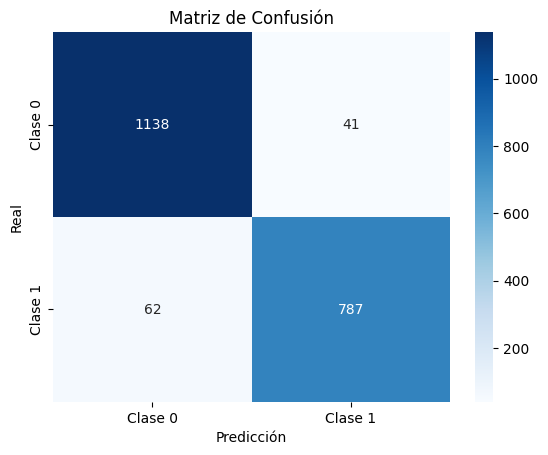

In [18]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_val_pred)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

In [19]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_grid.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importance)

           Feature  Importance
46    SIG_STR_DIFF    0.108040
2             KD_B    0.098883
45         KD_DIFF    0.051708
43  STR_GROUND_B_x    0.038793
50       CTRL_DIFF    0.037862
..             ...         ...
27    STR_BODY_B_x    0.002938
32     STR_LEG_B_y    0.002883
56        Record_B    0.002550
49        REV_DIFF    0.002320
10           REV_B    0.000000

[75 rows x 2 columns]


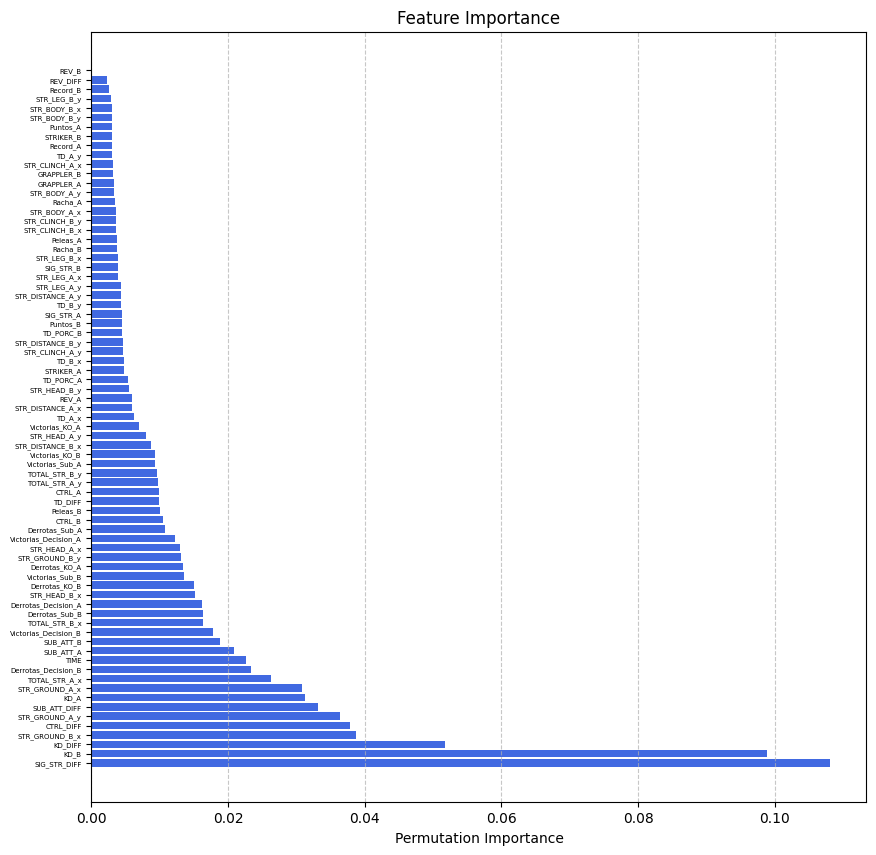

In [20]:
plt.figure(figsize=(10, 10))
plt.barh(feature_importance["Feature"], feature_importance["Importance"], color="royalblue")
plt.xlabel("Permutation Importance")
plt.title("Feature Importance")
plt.yticks(fontsize=5)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

Observamos que las variables más importantes son diferencias entre los golpes de los luchadores y los knockdowns.

In [21]:
def train_xgboost_random(X_train, y_train, X_val, y_val):
    # Calcular pesos de clase para manejar desbalance de datos
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    scale_pos_weight = class_weights[1] / class_weights[0] if len(class_weights) > 1 else 1

    # Definir modelo base
    xgb = XGBClassifier(random_state=42)

    # Distribución de hiperparámetros para búsqueda aleatoria
    param_dist = {
        'n_estimators': np.arange(50, 400, 50),
        'max_depth': np.arange(3, 30, 3),
        'learning_rate': np.linspace(0.01, 0.2, 10),
        'subsample': np.linspace(0.5, 1.0, 6),
        'colsample_bytree': np.linspace(0.5, 1.0, 6),
        'gamma': np.linspace(0, 0.5, 6),
        'min_child_weight': np.arange(1, 10, 2),
        'scale_pos_weight': [1, scale_pos_weight]
    }

    # Definir la métrica de optimización como el F1-score macro
    f1_scorer = make_scorer(f1_score, average='macro')
    
    # Búsqueda con validación cruzada
    random_search = RandomizedSearchCV(
        estimator=xgb,
        param_distributions=param_dist,
        scoring=f1_scorer,
        n_iter=50,
        cv=5,
        n_jobs=-1,
        verbose=2,
        random_state=42
    )

    # Entrenar el modelo
    random_search.fit(X_train, y_train)

    # Imprimir mejores parámetros
    print("Mejores parámetros:", random_search.best_params_)

    # Evaluar el mejor modelo en el conjunto de validación
    y_pred = random_search.best_estimator_.predict(X_val)
    print("Reporte de clasificación:")
    print(classification_report(y_val, y_pred))

    return random_search.best_estimator_,random_search.best_params_

In [22]:
print("-- Entrenamiento usando ajuste de hiperparámetros con RandomizedSeachCV --")
best_random,best_params = train_xgboost_random(X_train,y_train,X_test,y_test)

-- Entrenamiento usando ajuste de hiperparámetros con RandomizedSeachCV --
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Mejores parámetros: {'subsample': np.float64(1.0), 'scale_pos_weight': np.float64(1.3191176470588235), 'n_estimators': np.int64(150), 'min_child_weight': np.int64(7), 'max_depth': np.int64(6), 'learning_rate': np.float64(0.1366666666666667), 'gamma': np.float64(0.5), 'colsample_bytree': np.float64(0.7)}
Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.96      0.96      0.96      1179
        True       0.95      0.94      0.94       849

    accuracy                           0.95      2028
   macro avg       0.95      0.95      0.95      2028
weighted avg       0.95      0.95      0.95      2028



In [ ]:
if mlflow.active_run():
    mlflow.end_run()

# Iniciar un nuevo experimento
with mlflow.start_run(run_name="Modelo usando RandomizedSearch"):

    # Guardar modelo en MLflow
    mlflow.log_param("mejores_parametros", best_params)
    mlflow.log_metric("accuracy", accuracy_score(y_test, y_val_pred))
    mlflow.log_metric("f1_macro", f1_val)

    print("Modelo guardado en MLflow")

c:\Users\mattu\OneDrive\Documentos\GitHub\c2425-R4\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:33:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/03/26 11:33:18 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/03/26 11:33:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo guardado en MLflow


In [24]:
print("-- Métricas del modelo con hiperparámetros ajustados --")
y_val_pred = best_random.predict(X_test)
y_val_prob = best_random.predict_proba(X_test)[:,1]
print("Accuracy:", accuracy_score(y_test, y_val_pred))
f1_val = f1_score(y_test, y_val_pred)
roc_auc_val = roc_auc_score(y_test, y_val_prob)
precision_val = precision_score(y_test, y_val_pred)
recall_val = recall_score(y_test, y_val_pred)
log_loss_val = log_loss(y_test,y_val_prob)

print(f"F1-Score: {f1_val:.4f}")
print(f"AUC-ROC: {roc_auc_val:.4f}")
print(f"Precisión: {precision_val:.4f}")
print(f"Sensibilidad: {recall_val:.4f}")
print(f"Log-loss: {log_loss_val}")

-- Métricas del modelo con hiperparámetros ajustados --
Accuracy: 0.9526627218934911
F1-Score: 0.9431
AUC-ROC: 0.9918
Precisión: 0.9487
Sensibilidad: 0.9376
Log-loss: 0.11452290522916732


Modelo muy similar al base

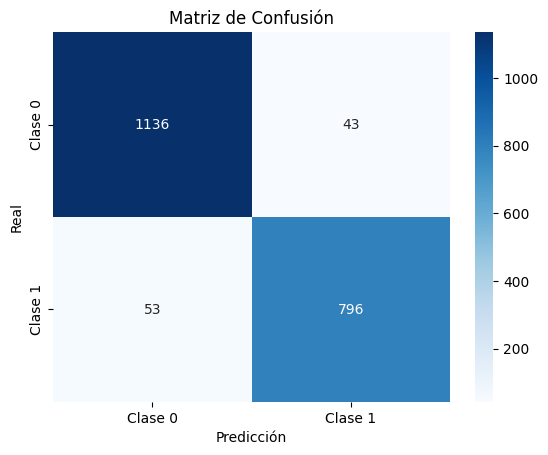

In [25]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_val_pred)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

In [26]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_random.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importance)

         Feature  Importance
46  SIG_STR_DIFF    0.141609
2           KD_B    0.139136
45       KD_DIFF    0.041082
50     CTRL_DIFF    0.038380
48  SUB_ATT_DIFF    0.034655
..           ...         ...
18        TD_A_y    0.002456
55      Record_A    0.002430
26  STR_BODY_A_y    0.002358
56      Record_B    0.002346
10         REV_B    0.000000

[75 rows x 2 columns]


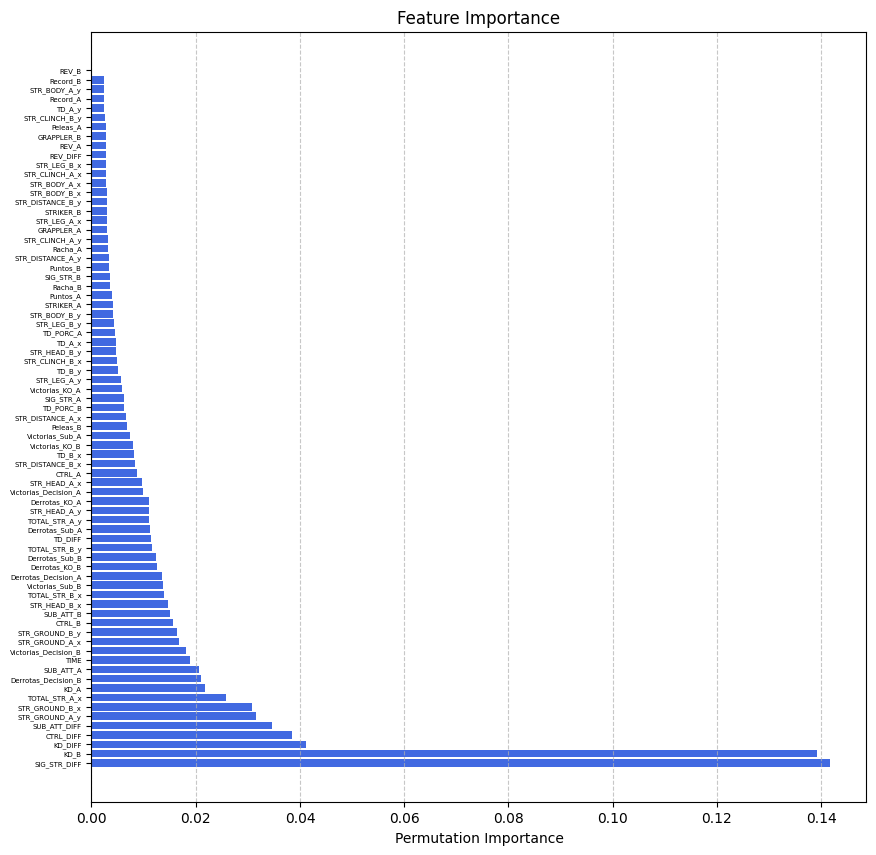

In [27]:
plt.figure(figsize=(10, 10))
plt.barh(feature_importance["Feature"], feature_importance["Importance"], color="royalblue")
plt.xlabel("Permutation Importance")
plt.title("Feature Importance")
plt.yticks(fontsize=5)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

Las importancias son las mismas que en el modelo encontrado con el modelo rejilla pero se concentra más importancia en la diferencia de golpes y los knockdowns del luchador B.

#### CONCLUSIONES

En este caso GridSearchCV consiguió mejorar ligeramente en el modelo base, el cual ya era muy bueno. En cambio RandomizedSearchCV no encontró ninguna combinación que mejorase las métricas del modelo base. La búsqueda en rejilla tuvo un coste computacional y tiempo de ejecución notablemente mayor comparado con la búsqueda aleatoria.

Como conclusión podemos decir que el modelo funciona bastante bien consiguiendo realizar una gran tasa de aciertos, dando mucha impoortancia a variables que creamos manualmente como las diferencias en ciertos aspectos de la pelea. Uno de los puntos fuertes de este modelo es capturar relaciones no lineales, esto puede hacer que las métricas sean mejores ya que tiene en cuenta las relaciones entre las diferntes variables